# Prostate cANcer graDe Assessment (PANDA) Challenge
### About The Challenge
The training set consists of around 11,000 whole-slide images of digitized H&E-stained biopsies originating from two centers. This is the largest public whole-slide image dataset available, one of the largest digital pathology datasets and best known challenges in the field.<br>
Diagnosis of PCa is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system. In this challenge, we will develop models for detecting PCa on images of prostate tissue samples, and estimate severity of the disease using the most extensive multi-center dataset on Gleason grading yet available. <br>
The grading process consists of finding and classifying cancer tissue into so-called Gleason patterns (3, 4, or 5) based on the architectural growth patterns of the tumor (Fig. 1). After the biopsy is assigned a Gleason score, it is converted into an ISUP grade on a 1-5 scale. The Gleason grading system is the most important prognostic marker for PCa, and the ISUP grade has a crucial role when deciding how a patient should be treated. There is both a risk of missing cancers and a large risk of overgrading resulting in unnecessary treatment. However, the system suffers from significant inter-observer variability between pathologists, limiting its usefulness for individual patients. This variability in ratings could lead to unnecessary treatment, or worse, missing a severe diagnosis.<br>
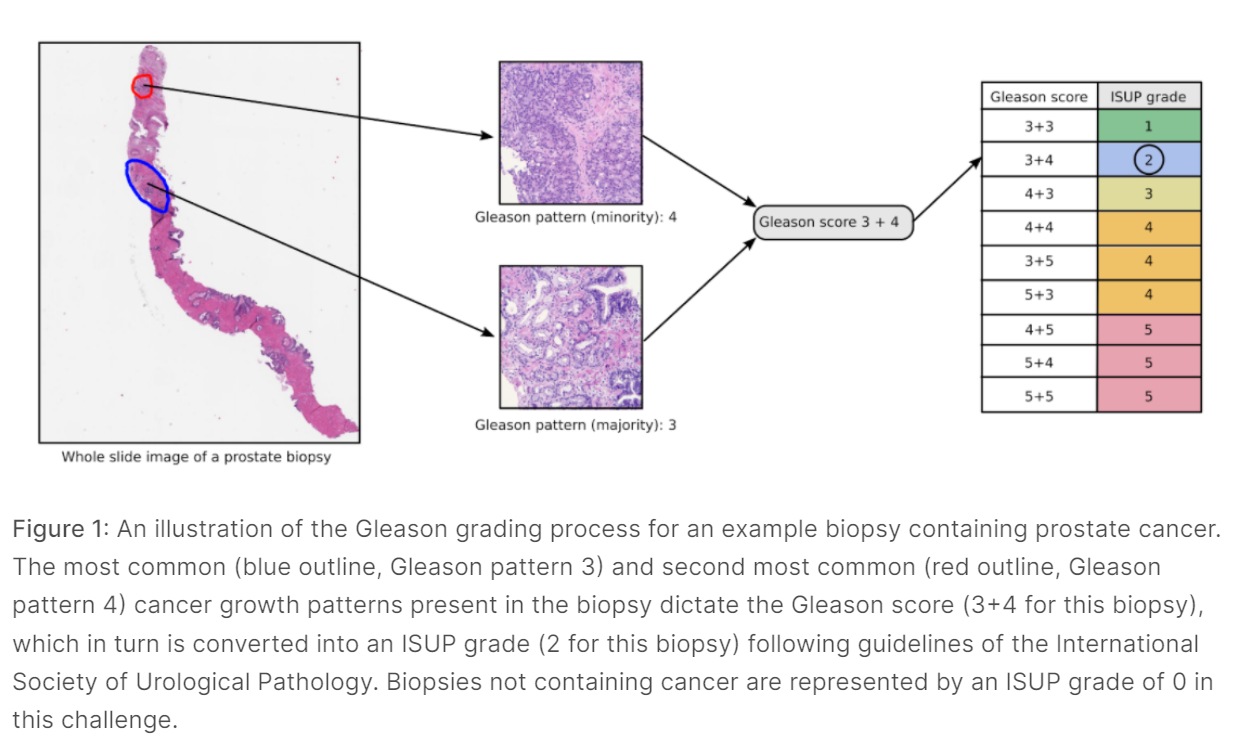

## My Approach
Instead of using the biopsy images directly as inputs to the model, I'll be using Iafoss's **Concatenate Tile Pooling** approach. I have explained this approach in [this](https://www.kaggle.com/norrsken/tiles) notebook. The approach basically breaks the biopsy images which contain a lot of empty space into 16 tiles of 128*128 blocks that contain the actual biopsies.<br><br>

I'll be using SE-ResNeXt-50 model with pretrained weights on 5 folds of input data provided. You can read more about Squeeze-And_Excitation Networks in this [paper](https://arxiv.org/pdf/1709.01507.pdf). I have replaced the last two FC layers with custom FC network that will be explained later.

In this notebook, I'll explain all the steps performed and help beginnners like myself understand how we can create a model for classifying the dataset into the 6 ISUP Scores.

In [ ]:
''' Imports '''
import os
import numpy as np
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict, Counter
from functools import partial
from sklearn import model_selection
from sklearn.metrics import cohen_kappa_score,confusion_matrix

import albumentations
import cv2
import openslide
import PIL
import skimage.io
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
TRAIN = '../input/prostate-cancer-grade-assessment/train_images/'
MASKS = '../input/prostate-cancer-grade-assessment/train_label_masks/'
TILES = '../input/tiles/'
MODEL = '../input/modelweights/se_resnext50_32x4d-a260b3a4.pth'
TEST_PATH = '../input/prostate-cancer-grade-assessment/test_images/'

TRAIN_BAT_SIZE = 16
VALID_BAT_SIZE = 32
DEVICE = 'cuda'
EPOCHS = 10
FOLDS = 5
TRAIN_FOLDS = {0 : [1,2,3,4], 1: [0,2,3,4], 2: [0,1,3,4], 3: [0,1,2,4], 4: [0,1,2,3]}
MODEL_MEAN=(0.485, 0.456, 0.406)
MODEL_STD=(0.229, 0.224, 0.225)

In [ ]:
train_csv = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv')

# Create 5 stratified folds for the data. Stratification helps distribute all classes equally across folds.
train_csv['kfolds'] = -1
kf = model_selection.StratifiedKFold(n_splits = FOLDS, shuffle = False, random_state = 10)
for fold, (train_idx, val_idx) in enumerate(kf.split(X = train_csv, y=train_csv.isup_grade.values)):
    print(len(train_idx), len(val_idx))
    train_csv.loc[val_idx, 'kfolds'] = fold
    
train_csv.to_csv('/kaggle/train_folds.csv', index = False)
train_csv = pd.read_csv('/kaggle/train_folds.csv')
train_csv

In [ ]:
class PANDADataset:
    def __init__(self, folds, mean, std):
        df = pd.read_csv('/kaggle/train_folds.csv')
        df = df[df.kfolds.isin(folds)].reset_index()
        df = df[['image_id', 'isup_grade']]
        self.image_ids = df.image_id.values
        self.isup_grade = df.isup_grade
        
        '''Normalize the images, Apply Shift/Scale/Rotate operations to training data with 0.8 probability.'''
        if len(folds) == 1:
            self.aug = albumentations.Compose([
                albumentations.Normalize(mean, std, always_apply = True)
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.ShiftScaleRotate(scale_limit = (1, 1.2), 
                                                rotate_limit = 180,
                                                p = 0.8),
                albumentations.Normalize(mean, std, always_apply = True)
            ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, item):
        tiles = Image.open(TILES + self.image_ids[item] + '.png').convert('RGB')
        tiles = np.transpose(tiles, (0, 1, 2)).astype(np.float32)
        tiles = self.aug(image = np.array(tiles))['image']
        tiles = torch.Tensor(tiles).permute(2, 0, 1)
        
        return {
            'image': tiles,
            'isup_grade': torch.tensor(self.isup_grade[item], dtype = torch.float),
        }

In [ ]:
"""
Code borrowed from
https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py
"""
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo

__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        # =====================> Changing this from AvgPool to AdaptiveAvgPool, so that all-dimensional inputs can be used. <=================================
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']
    
def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)

#========================================== to load the model from inputs instead of downloading from GitHub===============================================
#     model.load_state_dict(model_zoo.load_url(settings['url']))
    model.load_state_dict(torch.load(MODEL))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

## Model Architecture
 
I'll Fine Tune the model by removing last Two layers of the SE-ResNeXt50 model and replace them with the Fully Connected architecture as shown in the image below:
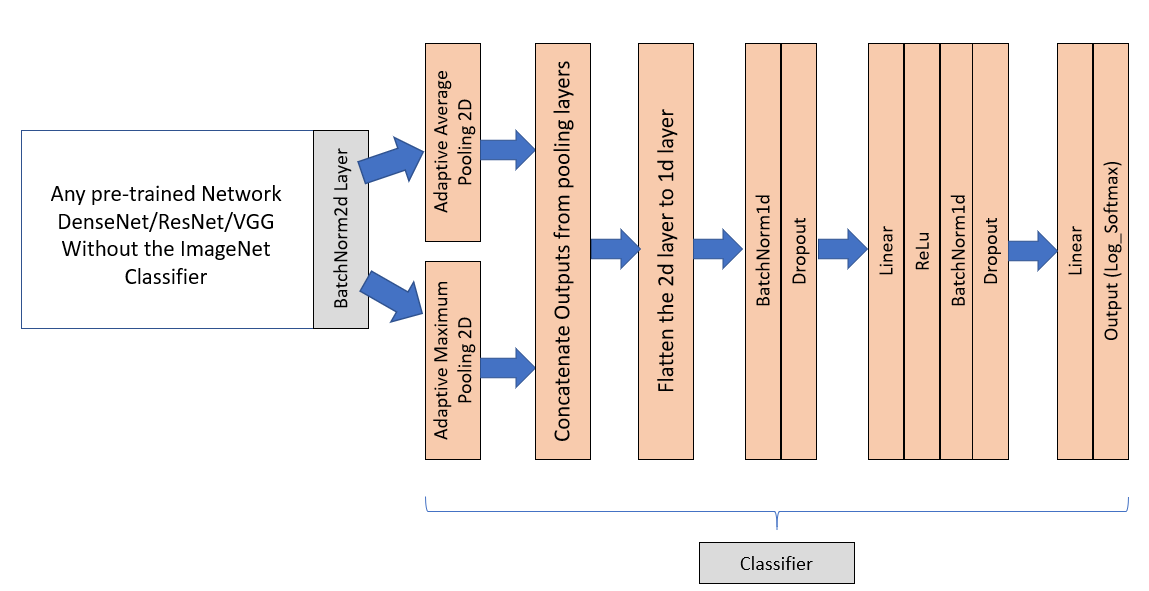

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SEResNext50(nn.Module):
    def __init__(self, h1=512, out = 1, d=0.5, freeze = False, pretrained = True):
        super().__init__()
        self.model = se_resnext50_32x4d()
        self.model = nn.Sequential(*list(self.model.children()))[:-2]
        inp = 2048
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False
        self.ap = nn.AdaptiveAvgPool2d((1,1))
        self.mp = nn.AdaptiveMaxPool2d((1,1))
        self.fla = Flatten()
        self.bn0 = nn.BatchNorm1d(2 * inp,eps=1e-05, momentum=0.1, affine=True)
        self.dropout0 = nn.Dropout(d)
        self.fc1 = nn.Linear(inp*2, h1)
        self.bn1 = nn.BatchNorm1d(h1,eps=1e-05, momentum=0.1, affine=True)
        self.dropout1 = nn.Dropout(d)
        self.fc2 = nn.Linear(h1, out)
        
    def forward(self, x):
        shape = x[0].shape
        x = self.model(x)
        ap = self.ap(x)
        mp = self.mp(x)
        x = torch.cat((ap,mp),dim=1)
        x = self.fla(x)
        x = self.bn0(x)
        x = self.dropout0(x)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)         
        x = self.fc2(x)
        return x

### Working of Optimized Rounder
We'll be giving equal weightage to the outputs of all the 5 models we have trained. We'll take the mean of all the predictions and then output the ISUP_Score using the result.<br>

The outputs of our models are continuous values and we need to convert them into one of the 6 ISUP Scores (ie. 0,1,2,3,4,5). For this conversion, we'll use optimized rounder. The optimized rounder works by creating ranges for each class and all the values lying in the certain range are given corresponding values.<br>
Components of Optimized Rounder:
**coefficients**: These are the coefficients that help define the value range for each class.<br>
for eg: we might set initial coefficients as \[0.5, 1.5, 2.5, 3.5, 4.5\], what this means is:<br>
Range     => Class<br>
-inf - 0.5 => 0<br>
0.5  - 1.5 => 1<br>
1.5  - 2.5 => 2<br>
... and so on.<br>

**fit**: We use the fit() to optimize our coefficients, so that the ranges are better selected according to our data.

In [ ]:
def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')


class OptimizedRounder():
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 4
            else:
                X_p[i] = 5
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
def train(dataset, data_loader, model, optimizer):
    model.train()
    avg_loss = 0
    for bi, d in tqdm(enumerate(data_loader), total = int(len(dataset) / data_loader.batch_size)):
        image = d['image']
        isup_grade = d['isup_grade']
        image = image.to(DEVICE, dtype = torch.float)
        isup_grade = isup_grade.to(DEVICE, dtype = torch.float)
        
        ''' Resets gradients to zero for at the start of every mini-batch, so as not mix up the gradients.'''
        optimizer.zero_grad()
        outputs = model(image)
        targets = isup_grade
        loss = loss_function(outputs.view(-1), targets)
        ''' Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter.
            This is why you should call optimizer.zero_grad() after each .step() call. 
            Note that following the first .backward call,
            a second call is only possible after you have performed another forward pass
        '''
        loss.backward()

        '''optimizer.step is performs a parameter update based on the current gradient 
           (stored in .grad attribute of a parameter) and the update rule
        '''
        optimizer.step()
        avg_loss += loss.item() / len(data_loader)
    return avg_loss

def eval(dataset, data_loader, model):
    model.eval()
    final_loss = 0
    final_score = 0
    counter = 0
    all_targets = []
    all_outputs = []
    for bi, d in tqdm(enumerate(data_loader), total = int(len(dataset) / data_loader.batch_size)):
        counter += 1
        image = d['image']
        isup_grade = d['isup_grade']
        
        image = image.to(DEVICE, dtype = torch.float)
        isup_grade = isup_grade.to(DEVICE, dtype = torch.float)
        
        outputs = model(image)
        targets = isup_grade
        
        all_outputs.append(outputs.view(-1))
        all_targets.append(targets)
        del image
        del outputs
        del targets
    all_targets = torch.cat(all_targets, 0)
    all_outputs = torch.cat(all_outputs, 0)
    loss = loss_function(all_outputs, all_targets) / len(data_loader)
    return loss, all_outputs, all_targets

def loss_function(outputs, targets):
    o = outputs
    t = targets
    
    l = nn.MSELoss()(o, t)
    
    return l

In [ ]:
def main(folds):
    model = SEResNext50()
    model.to(DEVICE)
    
    optimized_rounder = OptimizedRounder()
    
    train_dataset = PANDADataset(
        folds = TRAIN_FOLDS[folds],
        mean = MODEL_MEAN,
        std = MODEL_STD
    )
    
    train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset,
        batch_size = TRAIN_BAT_SIZE,
        shuffle = True,
        num_workers = 4
    )
    
    valid_dataset = PANDADataset(
        folds = [folds],
        mean = MODEL_MEAN,
        std = MODEL_STD
    )
    
    valid_loader = torch.utils.data.DataLoader(
        dataset = valid_dataset,
        batch_size = VALID_BAT_SIZE,
        shuffle = True,
        num_workers = 4
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min',
                                                          patience = 2, factor = 0.5, verbose = True)
    
    best_score = -100
    for epoch in tqdm(range(EPOCHS)):
        train_loss = train(train_dataset, train_loader, model, optimizer)
        with torch.no_grad():
            loss, all_outputs, all_targets = eval(valid_dataset, valid_loader, model)
        scheduler.step(loss)
        
        all_outputs = all_outputs.to('cpu').numpy()
        all_targets = all_targets.to('cpu').numpy()
        
        optimized_rounder.fit(all_outputs, all_targets)
        coefficients = optimized_rounder.coefficients()
        final_preds = optimized_rounder.predict(all_outputs, coefficients)
        print(f'Counter preds: {Counter(final_preds)}')
        print(f'coefficients: {coefficients}')
        score = quadratic_weighted_kappa(all_targets, final_preds)
        
        print(f'  Epoch {epoch+1} - avg_train_loss: {train_loss:.4f}  avg_val_loss: {loss:.4f}')
        print(f'  Epoch {epoch+1} - QWK: {score}  coefficients: {coefficients}')
        
        if score>best_score:
            best_score = score
            Predictions = all_outputs
            Targets = all_targets
            print(f'  Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model  coefficients: {coefficients}')
            torch.save(model.state_dict(), f'fold{folds}_se_resnext50.pth')
    return all_outputs, all_targets

In [ ]:
Predictions, Targets = [], []
for i in range(5):
    _outs, _labels = main(i)
    Predictions.append(_outs)
    Targets.append(_labels)

## Training Results

In [ ]:
preds = np.concatenate(Predictions)
valid_labels = np.concatenate(Targets)

optimized_rounder = OptimizedRounder()
optimized_rounder.fit(preds, valid_labels)
coefficients = optimized_rounder.coefficients()
final_preds = optimized_rounder.predict(preds, coefficients)
print(f'Counter preds: {Counter(final_preds)}')
print(f'coefficients: {coefficients}')

score = quadratic_weighted_kappa(valid_labels, final_preds)
print(f'CV QWK: {score}')

# Inference
Inference Notebook can be found [here](https://www.kaggle.com/norrsken/panda-prediction/edit/run/35532892).